In [1]:
import os
import shutil
import pandas as pd
import holidays
from time import time
from datetime import date, datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

In [3]:
start = pd.Timestamp("2017-01-01")
end = pd.Timestamp("2022-04-30")

# Aggregated demand data

In [4]:
def to_datetime(df, col_name):
    try:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))
    except:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%Y', utc=True))    
    df.index = df.index.date
    df.index = pd.to_datetime(df.index) 
    return df.index

## Trading Hub Europe: SLPs & RLMs

THE original data

In [5]:
#read
the_new = pd.read_csv(os.path.join(data_path, "Trading Hub Europe  Publications  Transparency  Aggregated consumption data.csv"), sep=";")
the_new.index = to_datetime(the_new, "Gasday")

#to numeric
the_new = the_new[the_new.columns[~the_new.columns.isin(["Gastag", "Status", "Gasday", "State"])]].fillna("0")
the_new = the_new.iloc[::-1] 
the_new = the_new.apply(lambda x: x.apply(lambda y: float(y.replace(".", "").replace(",", ""))))

#from kWh to TWh
the_new = the_new / (10**9)

In [6]:
def sum_consumptions(df):
    return pd.concat([
        df[df.filter(like=domain, axis=1).columns].sum(1) for domain in ["SLP", "RLM"]
    ], axis = 1, keys = ["slp", "rlm"]
    )

<AxesSubplot:>

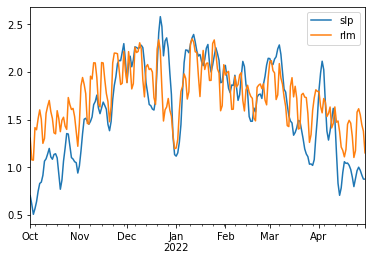

In [7]:
sum_consumptions(the_new).plot()

Gas pool data from: https://www.tradinghub.eu/de-de/Download/Archiv-GASPOOL / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [8]:
gaspool = pd.read_csv(os.path.join(data_path, "gaspool.csv"), sep=";")
gaspool.index = to_datetime(gaspool, "Datum")
gaspool.drop("Datum", axis=1, inplace=True)

#from MWh to TWh
gaspool = gaspool / (10**6)

<AxesSubplot:>

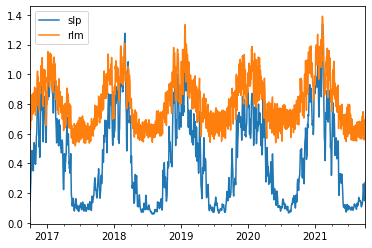

In [9]:
sum_consumptions(gaspool).plot()

NCG data from:https://www.tradinghub.eu/de-de/Download/Archiv-NetConnect-Germany / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [10]:
#in KWh
ncg = pd.read_csv(os.path.join(data_path, "ncg.csv"), sep=";")
ncg.index = to_datetime(ncg, "DayOfUse")

ncg.drop(["DayOfUse", "Status"], axis=1, inplace=True)
ncg.drop(list(ncg.filter(like='Unit', axis=1).columns), axis=1, inplace=True)

#from kWh to TWh
ncg = ncg / (10**9)

<AxesSubplot:>

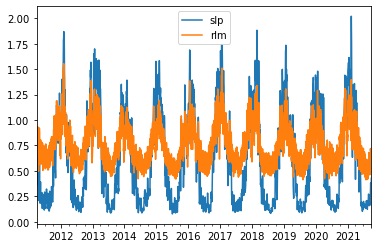

In [11]:
sum_consumptions(ncg).plot()

In [12]:
the = pd.concat([
    sum_consumptions(df) for df in [the_new, gaspool, ncg]
])
the = the.sort_index()


<AxesSubplot:>

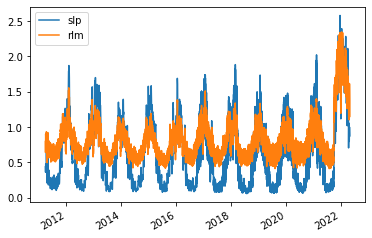

In [13]:
the.plot()

# Proxies / control variables / disaggregated demand
## Estimated SLP

In [14]:
estimated = pd.read_csv(os.path.join(data_path, "SLPs_new.csv"), index_col=0)
estimated.index = pd.to_datetime(
    pd.to_datetime(estimated.index).date
)

In [15]:
estimated["commercial"] = estimated[["commercial_space TWh", "commercial_water TWh"]].sum(1)
estimated["residential"] = estimated[["residential_space TWh", "residential_water TWh"]].sum(1)

Gas consumption according to AGEB in decentralized units will be mostly small CHP and hence temperature dependent. THis increases overall temperature-dependent gas consumption from 384 to 396 TWh.

In [16]:
def scaling(df, factor): 
    return df * factor / df[df.index.year==2020].sum()

In [17]:
estimated["scaled_space_private"] = scaling(estimated['residential'], 254)

estimated["scaled_space_tertiary"] = scaling(estimated['commercial'], 98)

estimated["scaled_decentral_chp"] = scaling(estimated['commercial'], 15)

estimated["scaled_space_industry"] = scaling(estimated['commercial'], 25)

#estimated["scaled_district_heat"] = scaling(estimated['dist_heat'], 19)

estimated['aggregated(incl_small_chp)'] = estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry"]
                                                   ].sum(1)


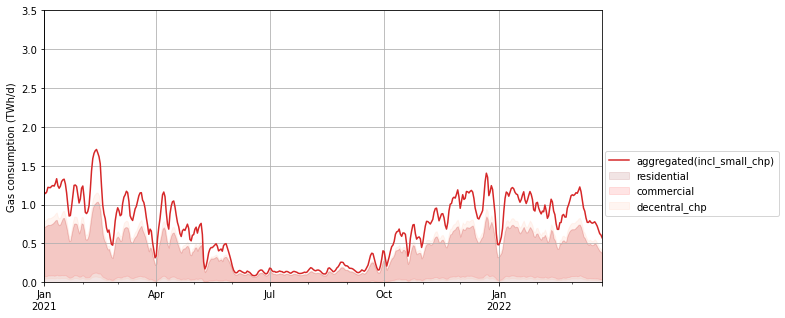

In [18]:
estimated.loc[estimated.index.year>=2021,'aggregated(incl_small_chp)'].plot(color='tab:red', figsize=(10,5))
plt.grid()

estimated2020 = estimated[estimated.index.year==2020]['aggregated(incl_small_chp)']
estimated2021 = estimated.loc["2021-01-01":]

plt.fill_between(estimated2020.index, 0, estimated2020, color='tab:red', alpha=0.1)

bottom = 0
for sector, c, label in [("scaled_space_private", "maroon", "residential"), (
    "scaled_space_industry","red", "commercial"), ("scaled_decentral_chp", "lightsalmon", "decentral_chp") ]:
    plt.fill_between(estimated2021.index, bottom, estimated2021[sector], color=c, alpha=0.1, label = label)
    bottom += estimated2021[sector]

plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.legend(loc='upper right', bbox_to_anchor=(1.325, 0.5))
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas for electricity generation

In [19]:
electricity_from_gas = pd.read_csv(os.path.join(data_path, "electricity_from_gas.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]

electricity_from_gas.index = pd.to_datetime(
    pd.to_datetime(electricity_from_gas.index).date
)
electricity_from_gas = electricity_from_gas /10**6

# earlier data

el_update = pd.read_csv(os.path.join(data_path, "entsoe_new.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]
el_update.index = pd.to_datetime(
    el_update.index.map(lambda x: x.date())
)

# concat

electricity_from_gas = pd.concat([el_update, electricity_from_gas], axis=0)

In [20]:
monthly_scaling = pd.read_csv(os.path.join(data_path, "nrg_cb_pem__custom_2931753_page_linear.csv"), 
                                   index_col="TIME_PERIOD", parse_dates=True)["OBS_VALUE"]
monthly_scaling.index = monthly_scaling.index = pd.to_datetime(
    pd.to_datetime(monthly_scaling.index).date
)

In [21]:
for date in monthly_scaling.index:
    conditions = ((electricity_from_gas.index.year==date.year) & 
                  (electricity_from_gas.index.month==date.month))
    electricity_from_gas[conditions] = electricity_from_gas[conditions] * monthly_scaling[date] / electricity_from_gas[conditions].sum() 

Scaled to 185 TWh in 2020, which is the sum of public power plants, public CHP, and industrial power plants (probably also mostly CHP):

In [22]:
gas_to_electricity = scaling(electricity_from_gas , 189)

gas_to_electricity_public_pp = scaling(electricity_from_gas, 106)

gas_to_electricity_public_chp = scaling(electricity_from_gas, 34)

electricity_from_gas.name = "electricity_from_gas"    
gas_to_electricity.name = "gas_to_electricity"  

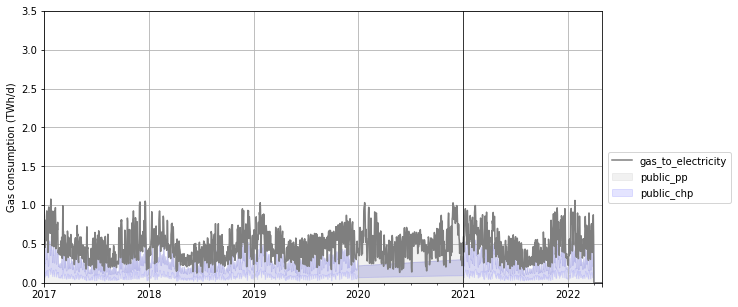

In [23]:
gas_to_electricity.plot(color='tab:grey', figsize=(10,5))
plt.grid()
power2020 = gas_to_electricity[gas_to_electricity.index.year==2020]
index_21_22 = gas_to_electricity[gas_to_electricity.index.year!=2020].index

plt.fill_between(power2020.index, 0, power2020, color='tab:grey', alpha=0.1)
plt.fill_between(index_21_22, 0, gas_to_electricity_public_pp[index_21_22], color='grey', alpha=0.1, label="public_pp")
plt.fill_between(index_21_22, gas_to_electricity_public_pp[index_21_22], gas_to_electricity_public_chp[index_21_22], color='blue', alpha=0.1, label="public_chp")


plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.5))
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.xlim(left=start, right=end)

plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas prices

In [24]:
gas_prices = pd.read_csv(os.path.join(data_path, "Dutch TTF Natural Gas Futures Recent.csv"), index_col=0)
gas_prices = gas_prices["Price"].to_frame().rename(columns={
    "Price":"gas_price [€/MWh]"}).dropna()
gas_prices.index = pd.to_datetime(gas_prices.index, utc = True).date

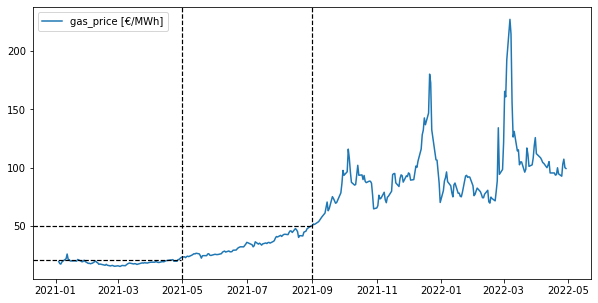

In [25]:
gas_prices.plot(figsize=(10,5))
plt.axvline(x="2021-09-1", color='k', linestyle='--', lw=1.2)
plt.axvline(x="2021-05-1", color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.5, y=50, color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.265, y=21, color='k', linestyle='--', lw=1.2)

In [26]:
def index_allignment(df):
    df.index = pd.DatetimeIndex(df.index)
    df = df.resample("D").mean()
    return df[df.index.duplicated()==False]

In [27]:
solar = pd.read_csv(os.path.join(data_path, "solar.csv"), index_col=0)
solar = index_allignment(solar)
solar = solar * 2.77778e-7 #J --> kWh
solar = solar.rename(columns={"solar [J/m^2]" : "solar [kWh/m^2]"})

temperature = pd.read_csv(os.path.join(data_path, "aggregated_temperature.csv"), index_col=0)
temperature =  index_allignment(temperature)



ref_temperature = pd.read_csv(os.path.join(data_path, "aggregated_reference_temperature.csv"), index_col=0)
ref_temperature = index_allignment(ref_temperature)

In [28]:
producing_sector = pd.read_csv(os.path.join(data_path, "manufacturing.csv"), index_col=0, sep=";", dtype={"Kalender- und saisonbereinigt nach X13 JDemetra+":float}, decimal=",")
producing_sector = producing_sector.iloc[:,0] #0: original, 1: adjusted values

producing_sector.index = pd.DatetimeIndex(producing_sector.index)
producing_sector = producing_sector.reindex(the.index, method = "ffill")
producing_sector.name = "producing_sector"


<AxesSubplot:>

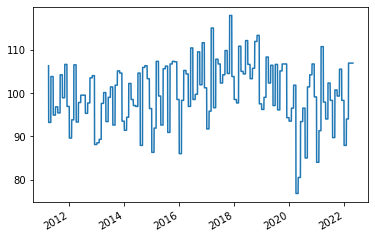

In [29]:
producing_sector.plot()

Combine sources

In [30]:
the = the.drop_duplicates()

In [31]:
df_all = the.join(
    [gas_to_electricity, electricity_from_gas, 
        gas_prices, producing_sector, estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry", 'aggregated(incl_small_chp)']
                                                   ]
    ]
)


In [32]:
def unify_index(df):
    try:
        return df.loc[(df.index >= start) & (df.index <= end)]
    except:
        return df.loc[(df.index.date >= first) & (df.index.date <= last)]

In [33]:
df_all = unify_index(df_all)
df_all["time"] = range(len(df_all))

In [34]:
df_all.head()

,slp,rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],producing_sector,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,aggregated(incl_small_chp),time
2017-01-01,1.453618,0.873133,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,1.171694,0
2017-01-01,1.453618,0.873133,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,1.171694,1
2017-01-01,0.848671,0.800309,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,1.171694,2
2017-01-01,0.848671,0.800309,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,1.171694,3
2017-01-02,0.883640,0.980216,0.549828,234.902217,NaN,91.7,0.711529,0.335247,0.051313,0.085522,1.183612,4


In [35]:
df_all.tail()

,slp,rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],producing_sector,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,aggregated(incl_small_chp),time
2022-04-26,1.000138,1.613657,0.000476,0.203405,103.210,106.9,NaN,NaN,NaN,NaN,NaN,8607
2022-04-27,0.967825,1.550806,0.000441,0.188326,107.425,106.9,NaN,NaN,NaN,NaN,NaN,8608
2022-04-28,0.917909,1.445274,0.000320,0.136511,100.142,106.9,NaN,NaN,NaN,NaN,NaN,8609
2022-04-29,0.875773,1.378584,0.000332,0.141998,99.450,106.9,NaN,NaN,NaN,NaN,NaN,8610
2022-04-30,0.875213,1.150763,0.000214,0.091540,NaN,106.9,NaN,NaN,NaN,NaN,NaN,8611


# Export

In [36]:
df = df_all

In [37]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [38]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [39]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [40]:
df

,slp,rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],producing_sector,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2017-01-01,1.453618,0.873133,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-01,1.453618,0.873133,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-01,0.848671,0.800309,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-01,0.848671,0.800309,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-02,0.883640,0.980216,0.549828,234.902217,NaN,91.7,0.711529,0.335247,0.051313,0.085522,...,2017,1,Monday,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,1.000138,1.613657,0.000476,0.203405,103.210,106.9,NaN,NaN,NaN,NaN,...,2022,4,Tuesday,1,0,0,0,0,0,0
2022-04-27,0.967825,1.550806,0.000441,0.188326,107.425,106.9,NaN,NaN,NaN,NaN,...,2022,4,Wednesday,2,0,0,0,0,0,0
2022-04-28,0.917909,1.445274,0.000320,0.136511,100.142,106.9,NaN,NaN,NaN,NaN,...,2022,4,Thursday,3,0,0,0,0,0,0
2022-04-29,0.875773,1.378584,0.000332,0.141998,99.450,106.9,NaN,NaN,NaN,NaN,...,2022,4,Friday,4,0,1,0,0,0,0


In [41]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))

In [42]:
df

,slp,rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],producing_sector,scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2017-01-01,1.453618,0.873133,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-01,1.453618,0.873133,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-01,0.848671,0.800309,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-01,0.848671,0.800309,0.325731,139.161499,NaN,101.2,0.728968,0.314400,0.048122,0.080204,...,2017,1,Sunday,6,0,0,1,0,1,0
2017-01-02,0.883640,0.980216,0.549828,234.902217,NaN,91.7,0.711529,0.335247,0.051313,0.085522,...,2017,1,Monday,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,1.000138,1.613657,0.000476,0.203405,103.210,106.9,NaN,NaN,NaN,NaN,...,2022,4,Tuesday,1,0,0,0,0,0,0
2022-04-27,0.967825,1.550806,0.000441,0.188326,107.425,106.9,NaN,NaN,NaN,NaN,...,2022,4,Wednesday,2,0,0,0,0,0,0
2022-04-28,0.917909,1.445274,0.000320,0.136511,100.142,106.9,NaN,NaN,NaN,NaN,...,2022,4,Thursday,3,0,0,0,0,0,0
2022-04-29,0.875773,1.378584,0.000332,0.141998,99.450,106.9,NaN,NaN,NaN,NaN,...,2022,4,Friday,4,0,1,0,0,0,0
